## Simulate isoplanatic imaging for LOW at 100MHz.

### A set of model components are drawn from GLEAM. An ionospheric screen model is used to calculate the pierce points of the two stations in an interferometer for a given component. The model visibilities are calculated directly, and screen phase applied to obtain the corrupted visibility.

In [1]:
%matplotlib inline

import sys

from data_models.parameters import arl_path

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants as const
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt
from matplotlib import pylab as pylab

from data_models.memory_data_models import SkyModel
from data_models.polarisation import PolarisationFrame

from processing_library.util.coordinate_support import simulate_point, skycoord_to_lmn

from wrappers.serial.calibration.calibration_control import calibrate_function, create_calibration_controls
from wrappers.serial.skycomponent.operations import find_skycomponents, partition_skycomponent_neighbours

from wrappers.serial.visibility.base import create_blockvisibility, copy_visibility
from processing_library.image.operations import copy_image
from wrappers.serial.image.operations import show_image, qa_image, show_components
from wrappers.serial.simulation.testing_support import create_named_configuration, \
    create_low_test_skycomponents_from_gleam, create_unittest_components
from wrappers.serial.skycomponent.operations import filter_skycomponents_by_flux
from wrappers.serial.simulation.mpc import create_gaintable_from_screen, sum_visibility_over_partitions, \
    calculate_sf_from_screen
from wrappers.serial.skymodel.operations import show_skymodel

from processing_components.simulation.mpc import expand_skymodel_by_skycomponents

from wrappers.serial.imaging.primary_beams import create_low_test_beam
from wrappers.serial.skycomponent.operations import apply_beam_to_skycomponent
from wrappers.serial.imaging.base import create_image_from_visibility, advise_wide_field
from wrappers.serial.image.operations import import_image_from_fits, export_image_to_fits

from wrappers.arlexecute.visibility.coalesce import convert_blockvisibility_to_visibility
from wrappers.arlexecute.skycomponent.operations import insert_skycomponent
from wrappers.arlexecute.image.operations import smooth_image

from workflows.arlexecute.pipelines.pipeline_arlexecute import continuum_imaging_list_arlexecute_workflow, \
    ical_list_arlexecute_workflow
from workflows.serial.imaging.imaging_serial import invert_list_serial_workflow
from workflows.serial.imaging.imaging_serial import weight_list_serial_workflow, taper_list_serial_workflow
from workflows.serial.pipelines.pipeline_serial import continuum_imaging_list_serial_workflow, \
    ical_list_serial_workflow

from data_models.data_model_helpers import import_blockvisibility_from_hdf5

from wrappers.arlexecute.execution_support.arlexecute import arlexecute
from wrappers.arlexecute.execution_support.dask_init import get_dask_Client

In [2]:
import logging
def init_logging():
    logging.basicConfig(filename='low-sims-mpc-process-iso.log',
                        filemode='a',
                        format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                        datefmt='%H:%M:%S',
                        level=logging.DEBUG)

init_logging()
log = logging.getLogger()
    
def lprint(*args):
    log.info(*args)
    print(*args)

In [3]:
pylab.rcParams['figure.figsize'] = (14.0, 14.0)
pylab.rcParams['image.cmap'] = 'rainbow'

In [4]:
c = get_dask_Client(
    memory_limit=64 * 1024 * 1024 * 1024, n_workers=16, threads_per_worker=1)
arlexecute.set_client(c)
# Initialise logging on the workers. This appears to only work using the process scheduler.
arlexecute.run(init_logging)

/home/timcornwell/anaconda3/envs/arl/lib/python3.6/site-packages/distributed/bokeh/core.py:55: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


Creating LocalCluster and Dask Client
Diagnostic pages available on port http://127.0.0.1:36323


{'tcp://127.0.0.1:33507': None,
 'tcp://127.0.0.1:34261': None,
 'tcp://127.0.0.1:36303': None,
 'tcp://127.0.0.1:36307': None,
 'tcp://127.0.0.1:37029': None,
 'tcp://127.0.0.1:38293': None,
 'tcp://127.0.0.1:38639': None,
 'tcp://127.0.0.1:39505': None,
 'tcp://127.0.0.1:40211': None,
 'tcp://127.0.0.1:42571': None,
 'tcp://127.0.0.1:43233': None,
 'tcp://127.0.0.1:43731': None,
 'tcp://127.0.0.1:43999': None,
 'tcp://127.0.0.1:44163': None,
 'tcp://127.0.0.1:44287': None,
 'tcp://127.0.0.1:44993': None}

### Set up the observation: 10 minutes at transit, with 10s integration.

In [5]:
rmax = 10000.0
blockvis = import_blockvisibility_from_hdf5('low-sims-skymodel_iso_blockvis_rmax10000.0.hdf5')

In [6]:
nfreqwin = len(blockvis.frequency)
ntimes = len(blockvis.time)
frequency = blockvis.frequency
times = blockvis.time
phasecentre = blockvis.phasecentre

### Find sampling, image size, etc

In [7]:
vis = convert_blockvisibility_to_visibility(blockvis)
advice = advise_wide_field(vis, guard_band_image=2.0, delA=0.02)

cellsize = advice['cellsize']
vis_slices = advice['vis_slices']
npixel = advice['npixels2']
if npixel > 1024:
    deconvolve_facets = 8
    deconvolve_overlap = 32
    deconvolve_taper = 'tukey'
else:
    deconvolve_facets = 1
    deconvolve_overlap = 0
    deconvolve_taper = 'tukey'

In [8]:
from workflows.arlexecute.imaging.imaging_arlexecute import invert_list_arlexecute_workflow
model = create_image_from_visibility(
    blockvis,
    npixel=npixel,
    frequency=frequency,
    nchan=nfreqwin,
    cellsize=cellsize,
    phasecentre=phasecentre)

small_model = create_image_from_visibility(
    blockvis,
    npixel=512,
    frequency=frequency,
    nchan=nfreqwin,
    cellsize=cellsize,
    phasecentre=phasecentre)

vis = convert_blockvisibility_to_visibility(blockvis)
vis = weight_list_serial_workflow([vis], [small_model])[0]
vis = taper_list_serial_workflow([vis], 3 * cellsize)[0]

vis_list = arlexecute.scatter([vis])
model_list = arlexecute.scatter([model])

dirty_list = invert_list_arlexecute_workflow(vis_list, model_list, dopsf=False, context='timeslice', 
                                             vis_slices=16) 

dirty_list = arlexecute.compute(dirty_list, sync=True)[0]


arlexecute.compute: Execution using Dask took 21.001 seconds


Quality assessment:
	Origin: qa_image
	Context: 
	Data:
		shape: '(1, 1, 4096, 4096)'
		max: '2.4645231559548235'
		min: '-0.3576966473006738'
		rms: '0.06840291041366754'
		sum: '101.41168715127506'
		medianabs: '0.04469922055486085'
		median: '-0.0011382311664582994'



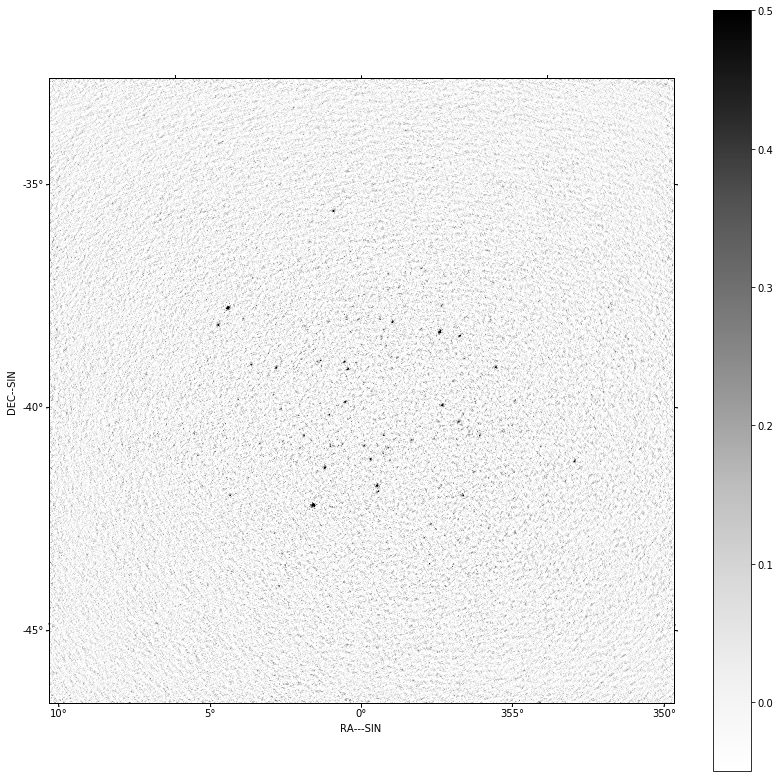

In [9]:
show_image(dirty_list[0], vmax=0.5, vmin=-0.05)
print(qa_image(dirty_list[0]))
plt.show()

In [10]:
cimg_list = continuum_imaging_list_arlexecute_workflow(
    vis_list,
    model_imagelist=model_list,
    context='timeslice',
    vis_slices=16,
    algorithm='msclean',
    scales=[0,3,10],
    niter=1000,
    fractional_threshold=0.5,
    threshold=0.5,
    nmajor=5,
    gain=0.1,
    psf_support=512,
    deconvolve_facets=8,
    deconvolve_overlap=32,
    deconvolve_taper='tukey')
    
cimg_deconvolved, cimg_residual, cimg_restored = arlexecute.compute(cimg_list, sync=True)

arlexecute.compute: Execution using Dask took 257.953 seconds


In [11]:
from processing_components.skycomponent.operations import find_skycomponents
recovered_cimg_components = find_skycomponents(cimg_restored[0], fwhm=2, threshold=0.5, npixels=12)
print(len(recovered_cimg_components))
print(recovered_cimg_components[0])

19
Skycomponent:
	Name: Segment 0
	Flux: [[2.38050183]]
	Frequency: [1.e+08]
	Direction: <SkyCoord (ICRS): (ra, dec) in deg
    (1.47765133, -42.58141241)>
	Shape: Point
	Params: {}
	Polarisation frame: stokesI



Quality assessment:
	Origin: qa_image
	Context: 
	Data:
		shape: '(1, 1, 4096, 4096)'
		max: '2.473281393031574'
		min: '-0.3243390517836186'
		rms: '0.06121426050852023'
		sum: '608.8655946455592'
		medianabs: '0.040236011781146525'
		median: '-0.0007679185308620255'



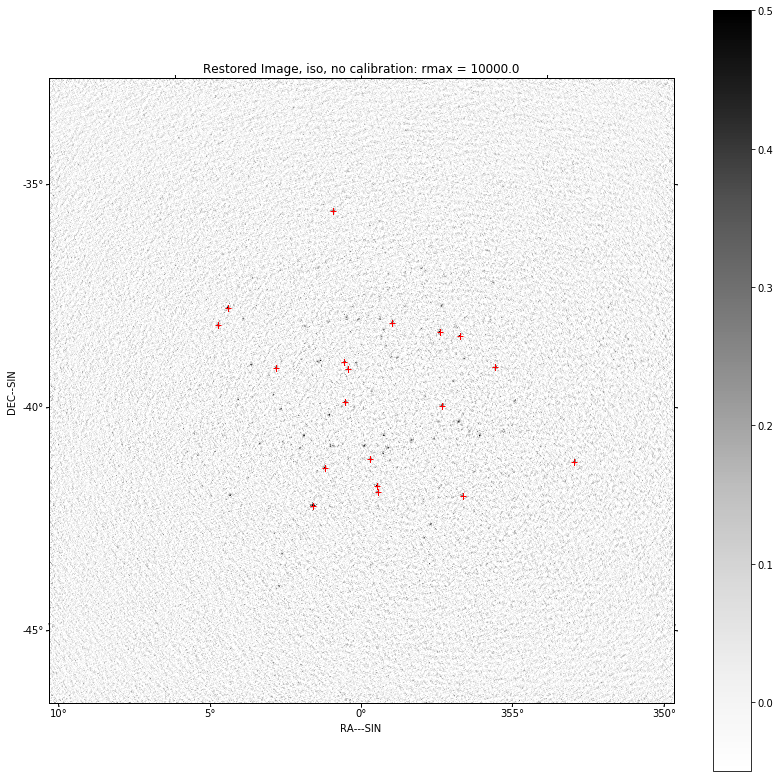

In [12]:
lprint(qa_image(cimg_restored[0]))
show_image(
    cimg_restored[0],
    cm='Greys',
    components=recovered_cimg_components,
    title='Restored Image, iso, no calibration: rmax = %.1f' % rmax,
    vmax=0.5, vmin=-0.05)

plt.savefig('low-sims-iso_cimg_restored_rmax%.1f.png' % rmax)
plt.show()

export_image_to_fits(cimg_restored[0],
                     'low-sims-iso_cimg_restored_rmax%.1f.fits' % rmax)
export_image_to_fits(cimg_residual[0][0],
                     'low-sims-iso_cimg_residual_rmax%.1f.fits' % rmax)

In [13]:
ical_model = copy_image(cimg_deconvolved[0])
ical_model.data[ical_model.data<0.1]=0.0
ical_model_list = arlexecute.scatter([ical_model])

In [14]:
controls = create_calibration_controls()

controls['T']['first_selfcal'] = 0
controls['T']['phase_only'] = True
controls['T']['timescale'] = 'auto'

ical_list = ical_list_arlexecute_workflow(
    vis_list,
    model_imagelist=ical_model_list,
    context='timeslice',
    vis_slices=16,
    algorithm='msclean',
    scales=[0,3,10],
    niter=1000,
    fractional_threshold=0.5,
    threshold=0.1,
    nmajor=10,
    gain=0.1,
    psf_support=512,
    deconvolve_facets=8,
    deconvolve_overlap=32,
    deconvolve_taper='tukey',
    timeslice='auto',
    global_solution=False,
    do_selfcal=True,
    calibration_context='T',
    controls=controls)
    
ical_deconvolved, ical_residual, ical_restored, gt_list = arlexecute.compute(ical_list, sync=True)

arlexecute.compute: Execution using Dask took 728.188 seconds


In [15]:
recovered_ical_components = find_skycomponents(ical_restored[0], fwhm=2, threshold=0.1, npixels=12)
print(len(recovered_ical_components))
print(recovered_ical_components[0])

162
Skycomponent:
	Name: Segment 0
	Flux: [[0.77088617]]
	Frequency: [1.e+08]
	Direction: <SkyCoord (ICRS): (ra, dec) in deg
    (2.5905445, -44.38637419)>
	Shape: Point
	Params: {}
	Polarisation frame: stokesI



Quality assessment:
	Origin: qa_image
	Context: 
	Data:
		shape: '(1, 1, 4096, 4096)'
		max: '4.929406617979484'
		min: '-0.0983437196865358'
		rms: '0.0191895181498752'
		sum: '4611.4654076442575'
		medianabs: '0.009264227453229596'
		median: '-5.6138344977068545e-06'



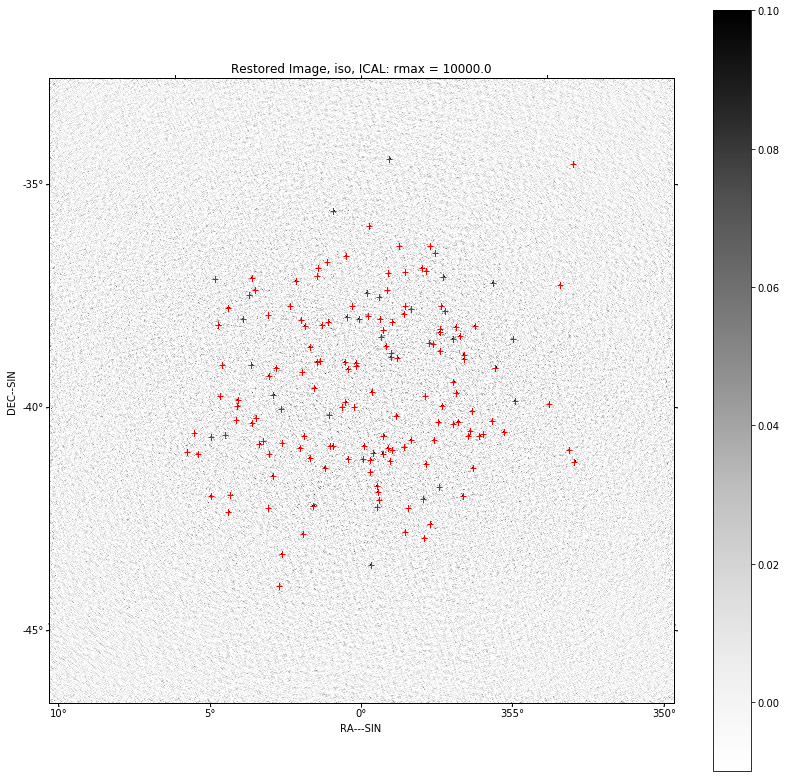

In [16]:
lprint(qa_image(ical_restored[0]))
show_image(
    ical_restored[0],
    components=recovered_ical_components,
    cm='Greys',
    title='Restored Image, iso, ICAL: rmax = %.1f' % rmax,
    vmax=0.1, vmin=-0.01)

plt.savefig('low-sims-cal_ical_restored_rmax%.1f.png' % rmax)
plt.show()

export_image_to_fits(ical_restored[0],
                     'low-sims-iso_ical_restored_rmax%.1f.fits' % rmax)
export_image_to_fits(ical_residual[0][0],
                     'low-sims-iso_ical_residual_rmax%.1f.fits' % rmax)

In [17]:
from data_models.data_model_helpers import import_skymodel_from_hdf5
gleam_skymodel_iso=import_skymodel_from_hdf5('low-sims-iso_skymodel.hdf5')

from processing_components.skycomponent.operations import filter_skycomponents_by_flux
bright_gleam=filter_skycomponents_by_flux(gleam_skymodel_iso.components, flux_min=0.1)
def max_flux(elem):
    return numpy.max(elem.flux)
sorted_bright_gleam=sorted(bright_gleam, key=max_flux, reverse=True)

KeyError: "Can't open attribute (can't locate attribute: 'phasecentre_coords')"

In [ ]:
from wrappers.serial.skycomponent.operations import find_skycomponent_matches
def max_flux(elem):
    return numpy.max(elem.flux)
sorted_recovered_ical_components=sorted(recovered_ical_components, key=max_flux, reverse=True)
matches = find_skycomponent_matches(sorted_recovered_ical_components, sorted_bright_gleam, tol=1e-3)
for match in matches:
    print(match)

In [ ]:
from wrappers.serial.skycomponent.operations import find_skycomponent_matches
matches = find_skycomponent_matches(sorted_recovered_ical_components, sorted_bright_gleam, tol=1e-3)
x=list()
y=list()
dx=list()
dy=list()
for match in matches:
    y.append(sorted_recovered_ical_components[match[0]].flux[0,0])
    x.append(sorted_bright_gleam[match[1]].flux[0,0])
    dx.append(sorted_recovered_ical_components[match[0]].direction.ra.rad-sorted_bright_gleam[match[1]].direction.ra.rad)
    dy.append(sorted_recovered_ical_components[match[0]].direction.dec.rad-sorted_bright_gleam[match[1]].direction.dec.rad)
    
plt.clf()
plt.plot(x, y, '.')
plt.xlim([0.0, 5.0])
plt.ylim([0.0, 5.0])
plt.xlabel('Input component flux')
plt.ylabel('Recovered component flux')
plt.title('Isoplanatic ICAL case: flux recovered')
plt.savefig('ical_iso_flux_errors.jpg')
plt.show()
    
plt.clf()
plt.plot(dx, dy, '.')
plt.xlim([-1e-3, 1e-3])
plt.ylim([-1e-3, 1e-3])
plt.xlabel('Error in RA (rad)')
plt.ylabel('Error in Dec (rad)')
plt.title('Isoplanatic ICAL case: position error')
plt.savefig('ical_iso_position_errors.jpg')
plt.show()
    
